# Prueba de conocimientos Claro Ensurance 

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import tensorflow as tf
import os
import pprint
import category_encoders as ce
pp = pprint.PrettyPrinter()
import tempfile
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import s3fs
import json
from sklearn.metrics.pairwise import cosine_similarity
import datetime
# scikit-learn modules for feature selection and model evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, SelectKBest, SelectFromModel, chi2, f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# libraries for visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# Importamos todas las hojas de excel como data frames

In [2]:
variables = pd.read_excel('sales_data_sample (1).xlsx', header = 0, sheet_name = 'Variables')
detalleOrden = pd.read_excel('sales_data_sample (1).xlsx', header = 0, sheet_name = 'DetalleOrden')
producto = pd.read_excel('sales_data_sample (1).xlsx', header = 0, sheet_name = 'Producto')
cliente = pd.read_excel('sales_data_sample (1).xlsx', header = 0, sheet_name = 'Cliente')
orden = pd.read_excel('sales_data_sample (1).xlsx', header = 0, sheet_name = 'Orden')


# Creamos una base de datos para subir las tablas

In [3]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///ventasMotos.db') 
dat=sqlite3.connect("ventasMotos.db")

In [4]:
variables.to_sql('Variables', con=engine, if_exists='append', index=False )
detalleOrden.to_sql('DetalleOrden', con=engine, if_exists='append', index=False )
producto.to_sql('Producto', con=engine, if_exists='append', index=False )
cliente.to_sql('Cliente', con=engine, if_exists='append', index=False )
orden.to_sql('Orden', con=engine, if_exists='append', index=False)


In [5]:
%load_ext sql
%config SqlMagic.autocommit=False # for engines that do not support autommit
%env DATABASE_URL=sqlite:///ventasMotos.db

env: DATABASE_URL=sqlite:///ventasMotos.db



# Hacemos una primera consulta a la basse de datos

In [6]:
%sql SELECT * FROM "DetalleOrden" limit 10

Done.


ORDERNUMBER,ID_Cliente,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,PRODUCTCODE,DEALSIZE
10107,C046,30,95.7,2,2871.0,S10_1678,Small
10121,C068,34,81.35,5,2765.9,S10_1678,Small
10134,C048,41,94.74,2,3884.34,S10_1678,Medium
10145,C087,45,83.26,6,3746.7,S10_1678,Medium
10159,C024,49,100.0,14,5205.27,S10_1678,Medium
10168,C081,36,96.66,1,3479.76,S10_1678,Medium
10180,C027,29,86.13,9,2497.77,S10_1678,Small
10188,C042,48,100.0,1,5512.32,S10_1678,Medium
10201,C058,22,98.57,2,2168.54,S10_1678,Small
10211,C009,41,100.0,14,4708.44,S10_1678,Medium


# Consulta para sacar los productos más vendidos

In [7]:
query = dat.execute(""" SELECT D.[PRODUCTCODE], P.[PRODUCTLINE], COUNT(*) AS [NUM_VENTAS]
                        FROM "DetalleOrden" D INNER JOIN 'Producto' P ON D.'PRODUCTCODE'= P.'PRODUCTCODE'
                        GROUP BY D.[PRODUCTCODE]  
                        ORDER BY  NUM_VENTAS desc """) 
cols = [column[0] for column in query.description]
mejorVendidos = pd.DataFrame.from_records(data = query.fetchall(), columns = cols)
mejorVendidos.head()

,PRODUCTCODE,PRODUCTLINE,NUM_VENTAS
0,S18_3232,Classic Cars,12480
1,S10_1949,Classic Cars,6720
2,S10_4962,Classic Cars,6720
3,S12_1666,Trucks and Buses,6720
4,S18_1097,Trucks and Buses,6720


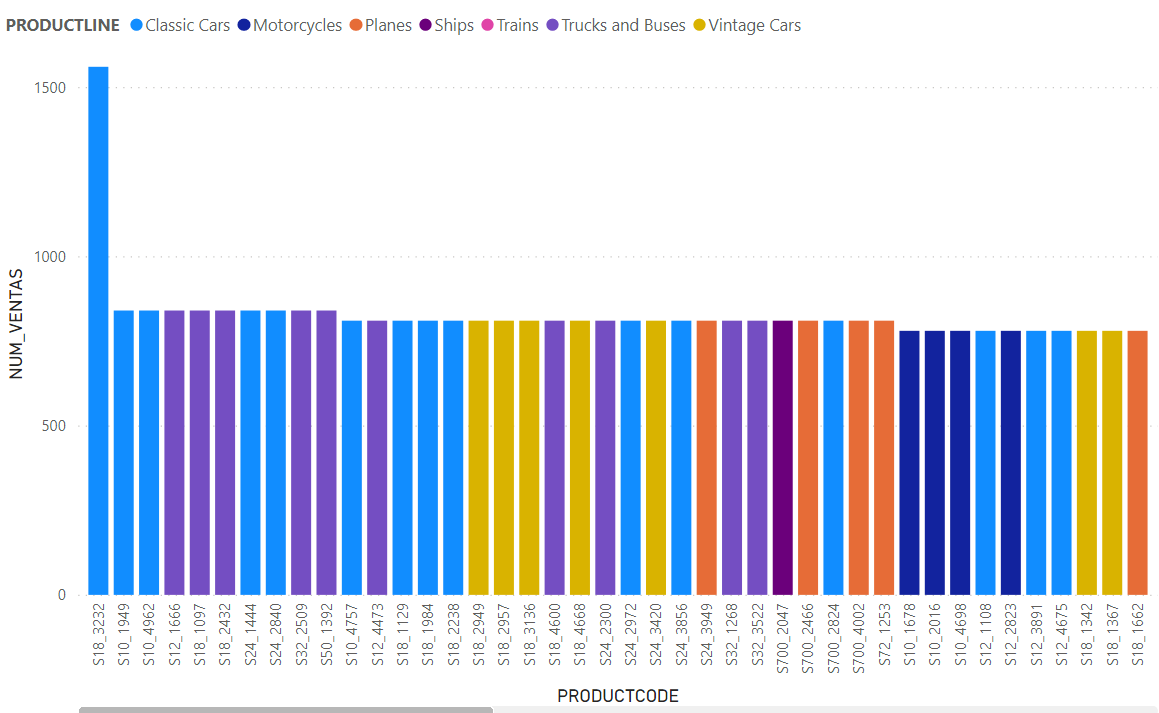

In [8]:
mejorVendidos.to_csv('mejorVendidos.csv',index=False)

# Consulta para sacar los consumos de los clientes

In [9]:
query = dat.execute("""SELECT D.[ID_CLIENTE], C.[CUSTOMERNAME], COUNT(*) AS [NUM_COMPRAS]
                       FROM "DetalleOrden" D INNER JOIN 'Cliente' C ON D.'ID_CLIENTE'= C.'ID_CLIENTE' 
                       GROUP BY D.[ID_Cliente]  
                       ORDER BY  NUM_COMPRAS desc""")
cols = [column[0] for column in query.description]
consumos = pd.DataFrame.from_records(data = query.fetchall(), columns = cols)
consumos.head()

,ID_Cliente,CUSTOMERNAME,NUM_COMPRAS
0,C034,Euro Shopping Channel,62160
1,C057,Mini Gifts Distributors Ltd.,43200
2,C006,"Australian Collectors, Co.",13200
3,C045,La Rochelle Gifts,12720
4,C011,"AV Stores, Co.",12240


In [10]:
consumos.to_csv('consumos.csv',index=False)

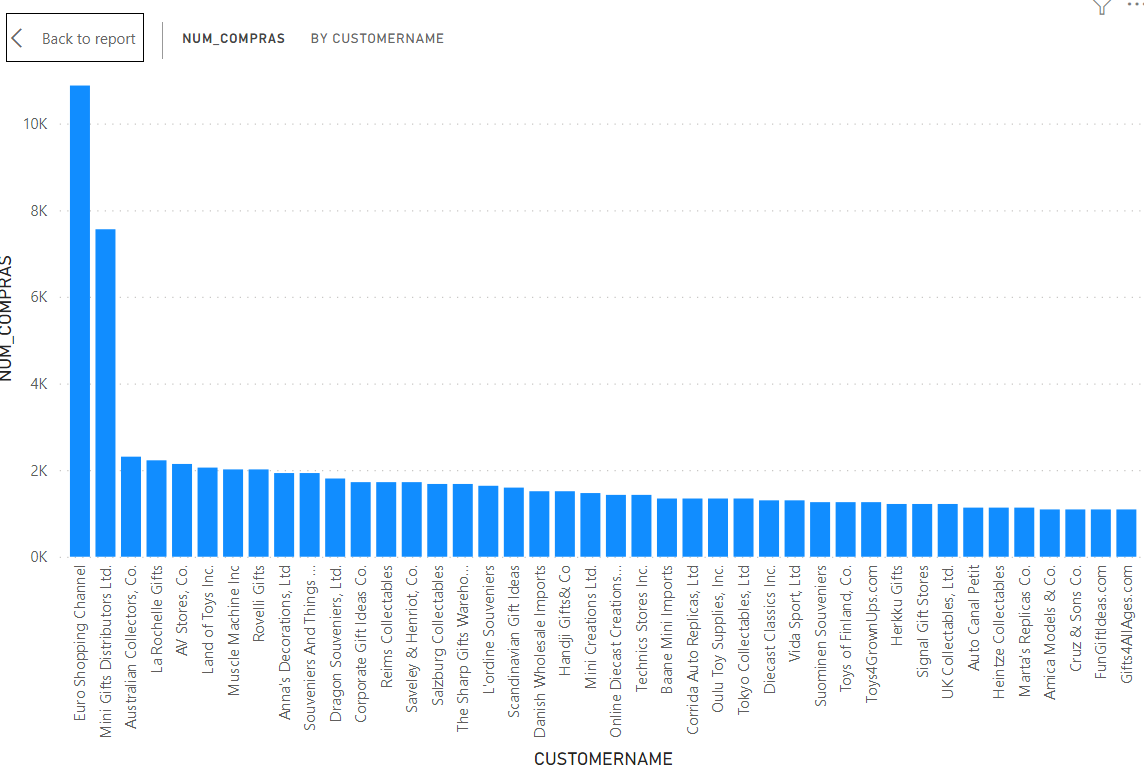


# Consulta para obtener el número de ventas por día 

In [11]:
query = dat.execute(""" SELECT O.[ORDERDATE], COUNT(*) AS [NUM_COMPRAS] 
                        FROM [DetalleOrden] D INNER JOIN [Orden] O ON D.[ORDERNUMBER]= O.[ORDERNUMBER]
                        GROUP BY O.[ORDERNUMBER]  
                        ORDER BY  NUM_COMPRAS desc""")
cols = [column[0] for column in query.description]
ventasFecha = pd.DataFrame.from_records(data = query.fetchall(), columns = cols)

ventasFecha.head()


,ORDERDATE,NUM_COMPRAS
0,2/17/2003 0:00,4320
1,10/10/2003 0:00,4320
2,10/22/2003 0:00,4320
3,10/28/2003 0:00,4320
4,2/19/2004 0:00,4320


In [12]:
ventasFecha.to_csv('ventasFecha.csv',index=False)

In [13]:
query = dat.execute( """SELECT ID_CLIENTE, 
                        max(O.ORDERDATE) AS LAST_ORDER_DATE,
                        COUNT(*) AS COUNT_ORDER,
                        AVG(SALES) AS AVG_SALES
                        FROM [DetalleOrden] D INNER JOIN [Orden] O ON D.[ORDERNUMBER]= O.[ORDERNUMBER]
                        GROUP BY ID_CLIENTE;""")
cols = [column[0] for column in query.description]
ultimaCompra = pd.DataFrame.from_records(data = query.fetchall(), columns = cols)

ultimaCompra .head()


,ID_Cliente,LAST_ORDER_DATE,COUNT_ORDER,AVG_SALES
0,C001,7/4/2003 0:00,4800,3524.422000
1,C002,9/9/2004 0:00,6240,3619.894615
2,C003,9/11/2003 0:00,11040,3347.741957
3,C004,9/27/2004 0:00,1680,3454.280000
4,C005,7/2/2004 0:00,5520,2808.324348


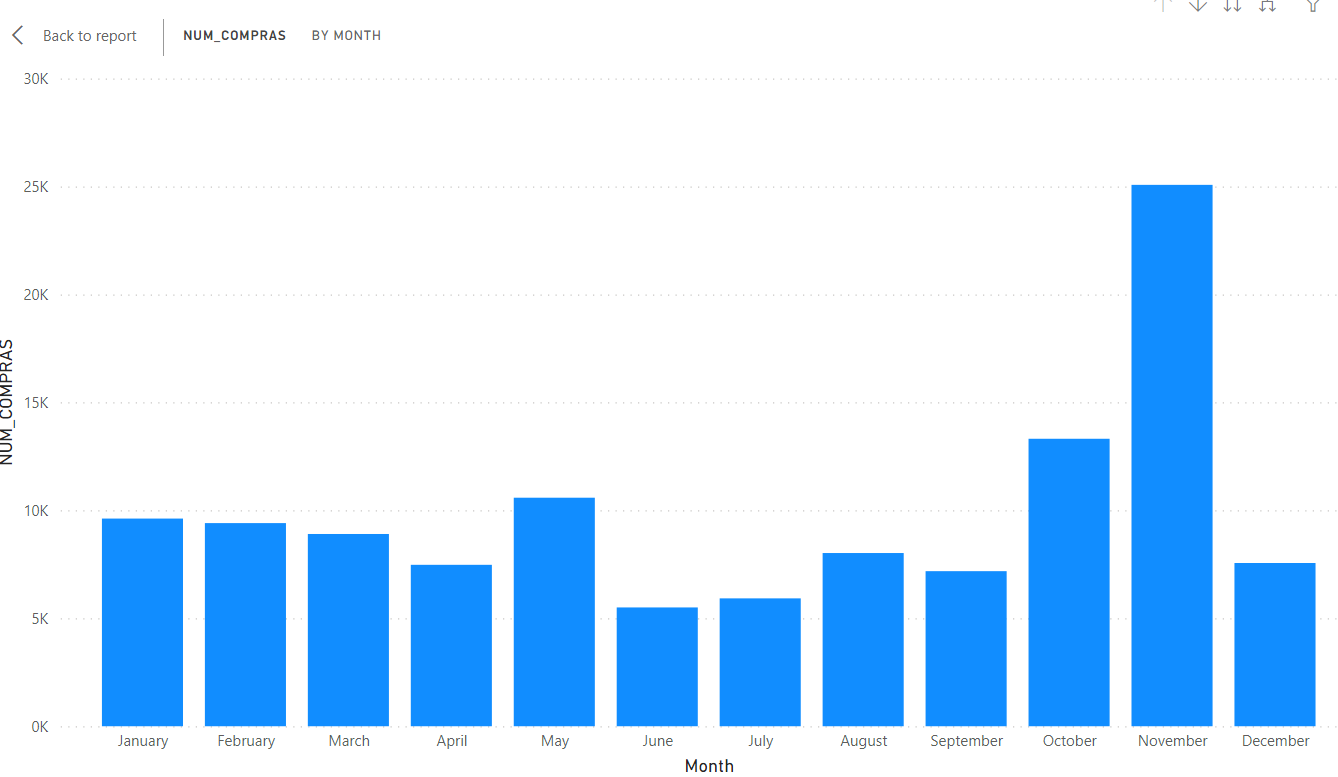

# Hacemos la segmentación de clientes RMF

In [14]:
query = dat.execute( """ SELECT ID_CLIENTE, 
                         ntile(4) over (order by LAST_ORDER_DATE) as rfm_recency,
                         ntile(4) over (order by COUNT_ORDER) as rfm_frequency,
                         ntile(4) over (order by AVG_SALES) as rfm_monetary
                         FROM 
                        (
                        SELECT ID_CLIENTE, 
                        max(O.ORDERDATE) AS LAST_ORDER_DATE,
                        COUNT(*) AS COUNT_ORDER,
                        AVG(SALES) AS AVG_SALES
                        FROM [DetalleOrden] D INNER JOIN [Orden] O ON D.[ORDERNUMBER]= O.[ORDERNUMBER]
                        GROUP BY ID_CLIENTE
                        )""")
cols = [column[0] for column in query.description]
lista = pd.DataFrame.from_records(data = query.fetchall(), columns = cols)

lista.head()

,ID_CLIENTE,rfm_recency,rfm_frequency,rfm_monetary
0,C051,1,1,2
1,C041,1,3,3
2,C019,1,2,1
3,C031,1,1,1
4,C043,1,1,3


# Ahora RMF combinado

In [15]:
query = dat.execute("""SELECT ID_CLIENTE, rfm_recency*100 + rfm_frequency*10 + rfm_monetary as rfm_combined 
                        FROM 
                        (SELECT ID_CLIENTE, 
                         ntile(4) over (order by LAST_ORDER_DATE) as rfm_recency,
                         ntile(4) over (order by COUNT_ORDER) as rfm_frequency,
                         ntile(4) over (order by AVG_SALES) as rfm_monetary
                         FROM 
                        (
                         SELECT ID_CLIENTE, 
                         max(O.ORDERDATE) AS LAST_ORDER_DATE,
                         COUNT(*) AS COUNT_ORDER,
                         AVG(SALES) AS AVG_SALES
                         FROM [DetalleOrden] D INNER JOIN [Orden] O ON D.[ORDERNUMBER]= O.[ORDERNUMBER]
                         GROUP BY ID_CLIENTE
                         )
                    )""")
cols = [column[0] for column in query.description]
res = pd.DataFrame.from_records(data = query.fetchall(), columns = cols)

res.head()

,ID_CLIENTE,rfm_combined
0,C051,112
1,C041,133
2,C019,121
3,C031,111
4,C043,113


# Clustering analysis

In [16]:
X = lista[['rfm_recency', 'rfm_frequency' ,'rfm_monetary']]
X

,rfm_recency,rfm_frequency,rfm_monetary
0,1,1,2
1,1,3,3
2,1,2,1
3,1,1,1
4,1,1,3
...,...,...,...
87,4,2,2
88,4,1,1
89,4,4,2
90,4,4,2


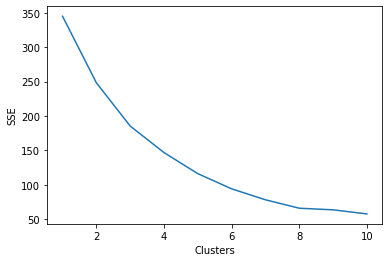

In [17]:

#elbow method
wcss = []
for i in range(1,11):
    k_means = KMeans(n_clusters=i,init='k-means++', random_state=42)
    k_means.fit(X)
    wcss.append(k_means.inertia_)
#plot elbow curve
plt.plot(np.arange(1,11),wcss)
plt.xlabel('Clusters')
plt.ylabel('SSE')
plt.show()

In [18]:

k_means_optimum = KMeans(n_clusters = 3, init = 'k-means++',  random_state=42)
y = k_means_optimum.fit_predict(X)
print(y)



[2 1 2 2 2 1 2 1 1 2 2 2 2 2 1 2 2 2 1 2 1 2 2 1 1 1 1 2 2 2 1 1 1 2 1 1 2
 1 1 2 2 1 2 1 1 2 1 1 1 1 0 1 0 0 0 0 1 0 1 1 1 0 1 1 0 0 0 1 1 0 0 0 0 0
 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0]


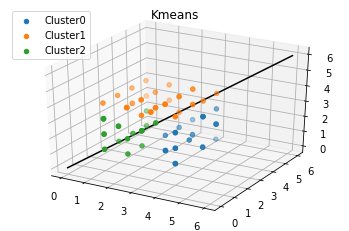

In [19]:
X['clusters']= y
dic = dict()
for i in range(8):
    dic[i] = X[X.clusters==i]

    
kplot = plt.axes(projection='3d')
xline = np.linspace(0, 6, 1000)
yline = np.linspace(0, 6, 1000)
zline = np.linspace(0, 6, 1000)
kplot.plot3D(xline, yline, zline, 'black')
# Data for three-dimensional scattered points
for i in range(3):
    kplot.scatter3D(dic[i].rfm_recency, dic[i].rfm_frequency, dic[i].rfm_monetary, label = 'Cluster'+str(i))
plt.legend()
plt.title("Kmeans")
plt.show()

    

# Imprimimos los clientes con su cluster correspondiente

In [20]:
X['ID_CLIENTE'] = lista['ID_CLIENTE']
X[['ID_CLIENTE', 'clusters']]

,ID_CLIENTE,clusters
0,C051,2
1,C041,1
2,C019,2
3,C031,2
4,C043,2
...,...,...
87,C023,0
88,C010,0
89,C074,0
90,C046,0


# Vamos a procesar los datos de detalleOrden para meterlos a un modelo de ML 

Vrificamos si hay NaN en la tabla detalle compra

In [21]:
detalleOrden.isna().sum()

ORDERNUMBER        0
ID_Cliente         0
QUANTITYORDERED    0
PRICEEACH          0
ORDERLINENUMBER    0
SALES              0
PRODUCTCODE        0
DEALSIZE           0
dtype: int64

In [22]:
# Removemos la columna id cliente 
columns_to_remove = ['ID_Cliente']
detalleOrden.drop(columns_to_remove, axis=1, inplace=True)

# Verificamos que la columna ha sido elimindas 
detalleOrden.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,PRODUCTCODE,DEALSIZE
0,10107,30,95.70,2,2871.00,S10_1678,Small
1,10121,34,81.35,5,2765.90,S10_1678,Small
2,10134,41,94.74,2,3884.34,S10_1678,Medium
3,10145,45,83.26,6,3746.70,S10_1678,Medium
4,10159,49,100.00,14,5205.27,S10_1678,Medium


Vamos a codificar las columnas PRODUCTODE Y DEALSIZE numericamente 

In [23]:
producto['ORD'] = producto.index +1

In [24]:
mergeD = pd.merge(detalleOrden,producto ,on='PRODUCTCODE')
mergeD['ORD']
detalleOrden['PRODUCTCODE'] = mergeD['ORD']
detalleOrden

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,PRODUCTCODE,DEALSIZE
0,10107,30,95.70,2,2871.00,1,Small
1,10121,34,81.35,5,2765.90,1,Small
2,10134,41,94.74,2,3884.34,1,Medium
3,10145,45,83.26,6,3746.70,1,Medium
4,10159,49,100.00,14,5205.27,1,Medium
...,...,...,...,...,...,...,...
2818,10350,20,100.00,15,2244.40,109,Small
2819,10373,29,100.00,1,3978.51,109,Medium
2820,10386,43,100.00,4,5417.57,109,Medium
2821,10397,34,62.24,1,2116.16,109,Small


In [25]:
for i in range(len(detalleOrden)):
    if detalleOrden['DEALSIZE'][i] =='Small':
        detalleOrden['DEALSIZE'][i] = 0
    elif detalleOrden['DEALSIZE'][i] =='Medium':
        detalleOrden['DEALSIZE'][i] = 1
    else:
        detalleOrden['DEALSIZE'][i] = 2
detalleOrden        

<ipython-input-25-d71d71936f92>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  detalleOrden['DEALSIZE'][i] = 0
<ipython-input-25-d71d71936f92>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  detalleOrden['DEALSIZE'][i] = 1
<ipython-input-25-d71d71936f92>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  detalleOrden['DEALSIZE'][i] = 2


,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,PRODUCTCODE,DEALSIZE
0,10107,30,95.70,2,2871.00,1,0
1,10121,34,81.35,5,2765.90,1,0
2,10134,41,94.74,2,3884.34,1,1
3,10145,45,83.26,6,3746.70,1,1
4,10159,49,100.00,14,5205.27,1,1
...,...,...,...,...,...,...,...
2818,10350,20,100.00,15,2244.40,109,0
2819,10373,29,100.00,1,3978.51,109,1
2820,10386,43,100.00,4,5417.57,109,1
2821,10397,34,62.24,1,2116.16,109,0


Ahora producimos la matiz de correlación de las variables

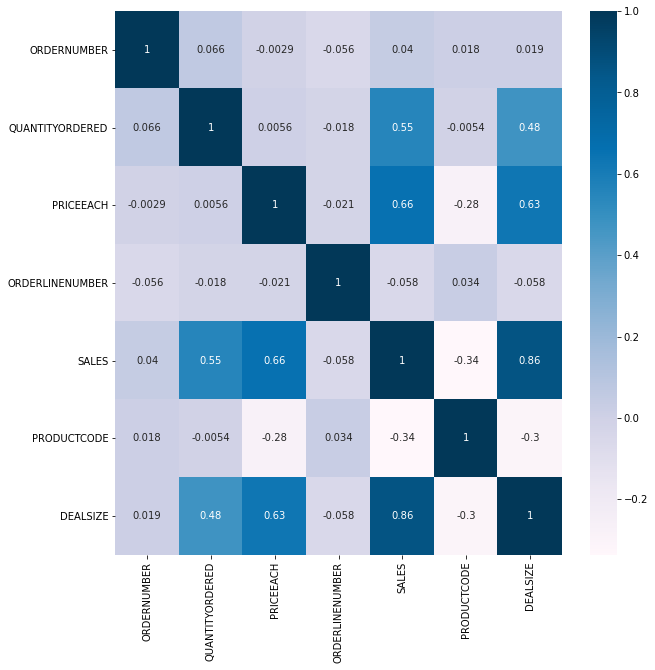

In [26]:
detalleOrden['DEALSIZE'] =pd.to_numeric(detalleOrden['DEALSIZE'])
# Set figure size

plt.figure(figsize=(10,10))

# Calculate correlation matrix
cor = detalleOrden.corr() 

# Plot the correlation matrix
sns.heatmap(cor, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [27]:
detalleOrden.columns

Index(['ORDERNUMBER', 'QUANTITYORDERED', 'PRICEEACH', 'ORDERLINENUMBER',
       'SALES', 'PRODUCTCODE', 'DEALSIZE'],
      dtype='object')

In [29]:
X = detalleOrden.drop([ 'QUANTITYORDERED', 'PRICEEACH', 'ORDERLINENUMBER'], axis = 1)
pivot_df = pd.pivot_table(X, index= 'ORDERNUMBER', columns ='PRODUCTCODE' ,values = 'SALES',aggfunc = 'count')

In [32]:
pivot_df.reset_index(inplace=True)
pivot_df = pivot_df.fillna(0)
pivot_df = pivot_df.drop('ORDERNUMBER', axis=1)

In [34]:
co_matrix = pivot_df.T.dot(pivot_df)
np.fill_diagonal(co_matrix.values, 0)

In [35]:
cos_score_df = pd.DataFrame(cosine_similarity(co_matrix))
cos_score_df.index = co_matrix.index
cos_score_df.columns = np.array(co_matrix.index)

In [36]:
cos_score_df.head(10)

,index,1,2,3,4,5,6,7,8,9,...,100,101,102,103,104,105,106,107,108,109
PRODUCTCODE,,,,,,,,,,,,,,,,,,,,,
index,1.000000,0.006494,0.006122,0.006556,0.006776,0.006708,0.007115,0.008100,0.006441,0.006177,...,0.008188,0.007811,0.007181,0.007142,0.007964,0.007340,0.007509,0.008403,0.007402,0.007704
1,0.006494,1.000000,0.999782,0.999961,0.999965,0.999804,0.999776,0.999833,0.999791,0.999782,...,0.999855,0.999772,0.999774,0.999917,0.999874,0.999749,0.999744,0.999838,0.999807,0.999737
2,0.006122,0.999782,1.000000,0.999777,0.999770,0.999788,0.999942,0.999731,0.999800,0.999963,...,0.999743,0.999750,0.999945,0.999761,0.999751,0.999739,0.999734,0.999739,0.999759,0.999727
3,0.006556,0.999961,0.999777,1.000000,0.999964,0.999811,0.999771,0.999798,0.999787,0.999778,...,0.999887,0.999781,0.999769,0.999945,0.999906,0.999753,0.999749,0.999869,0.999824,0.999741
4,0.006776,0.999965,0.999770,0.999964,1.000000,0.999800,0.999764,0.999805,0.999780,0.999771,...,0.999869,0.999770,0.999762,0.999934,0.999890,0.999744,0.999740,0.999851,0.999811,0.999732
5,0.006708,0.999804,0.999788,0.999811,0.999800,1.000000,0.999784,0.999744,0.999872,0.999789,...,0.999870,0.999968,0.999784,0.999814,0.999854,0.999946,0.999945,0.999890,0.999946,0.999940
6,0.007115,0.999776,0.999942,0.999771,0.999764,0.999784,1.000000,0.999731,0.999818,0.999959,...,0.999737,0.999744,0.999970,0.999754,0.999744,0.999733,0.999728,0.999733,0.999753,0.999721
7,0.008100,0.999833,0.999731,0.999798,0.999805,0.999744,0.999731,1.000000,0.999742,0.999734,...,0.999718,0.999707,0.999727,0.999752,0.999733,0.999693,0.999689,0.999710,0.999727,0.999682
8,0.006441,0.999791,0.999800,0.999787,0.999780,0.999872,0.999818,0.999742,1.000000,0.999806,...,0.999758,0.999867,0.999827,0.999770,0.999763,0.999883,0.999885,0.999759,0.999790,0.999883
